# Lipid quantitation MlaC




In [1]:
import os
import numpy as np
import math
import scipy.optimize
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import scipy.optimize as opt
from scipy.optimize import curve_fit
from scipy.signal import find_peaks
from scipy.optimize import minimize
%matplotlib notebook
matplotlib.rcParams['pdf.fonttype'] = 42

In [6]:
MS1file = 'C:/Users/chem-chem1762/Documents/Papers/Submitted/2025_Mla-system/Revision/new spectra/endogenous tagging/250118_MlaC_hypotonic_50V_noEFT_500k-qb_unidecfiles/250118_MlaC_hypotonic_50V_noEFT_500k-qb_mass.txt' 
#referencefile contains spectrum of MlaC + one lipid to determine peakwidth
lipidmassfile = 'C:/Users/chem-chem1762/Documents/Eclipse/240214_lipidquantitation/Lipidmasses.txt'
#lipidmassfile contains a list of lipidmasses from the MS2 spectrum
MS2file = 'C:/Users/chem-chem1762/Documents/Eclipse/240214_lipidquantitation/MS2.txt' 
#MS2file contains MS2 spectrum with released lipids

<IPython.core.display.Javascript object>


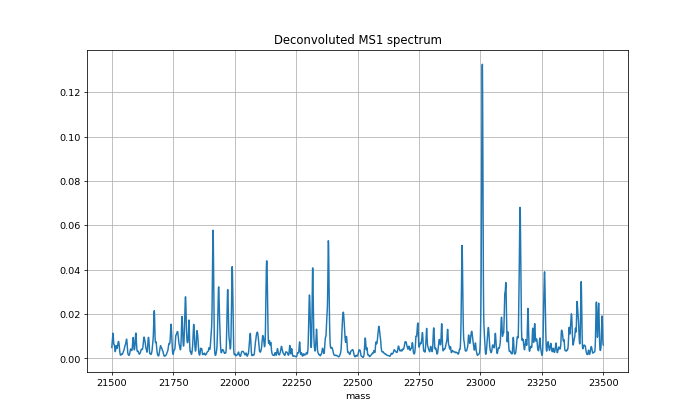

In [7]:
df = pd.read_csv(MS1file, sep=' ', names=['x', 'y'])
reduced_df = df[(df['x'] >= 25500) & (df['x'] <= 23500)]
plt.figure(figsize=(10, 6))  
plt.plot(reduced_df['x'], reduced_df['y'], linestyle='-')  
plt.title('Deconvoluted MS1 spectrum')
plt.xlabel('mass')
plt.grid(True)  
plt.show()

[2.02885024e-02 2.17893533e+04 1.30688304e-01 8.03289187e-02
 1.90123893e-01 8.11248503e-02 5.17646272e-02]


<IPython.core.display.Javascript object>


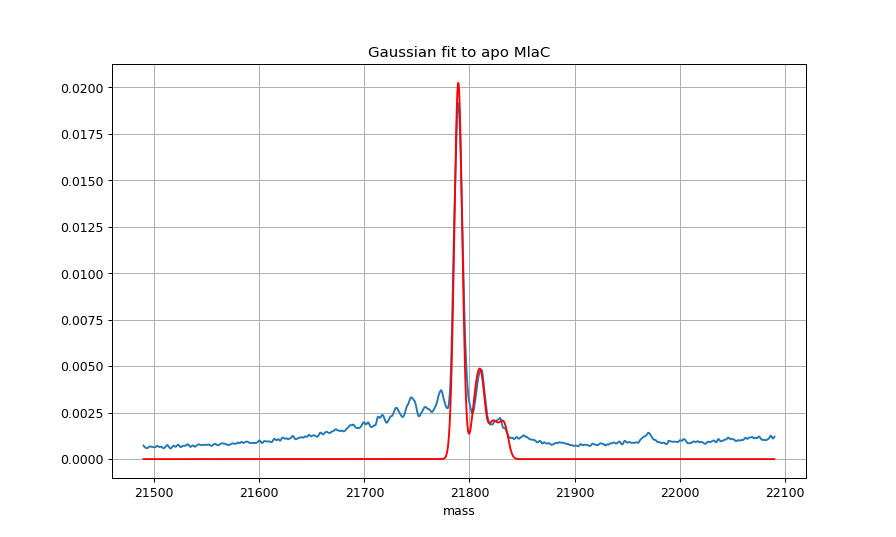

Peak center: 21789.35, FWHM: 8.87


In [11]:
df = pd.read_csv(MS1file, sep=' ', names=['x', 'y'])
spec_x = np.array(list(df['x'])[::5])
spec_y = np.array(list(df['y'])[::5])

indices = np.where((spec_x >= 22400) & (spec_x <= 22800))[0]
spec_x = spec_x[indices]
spec_y = spec_y[indices]
spec_y = spec_y/max(spec_y)*100

def gaussian(x, a, b, d, e, f, g, h):
    c = 3.7664
    apo = a * np.exp(-((x - b) ** 2) / (2 * c ** 2)) 
    ox1 = a * d * np.exp(-((x - (b+16)) ** 2) / (2 * c ** 2)) 
    ox2 = a * e * np.exp(-((x - (b+32)) ** 2) / (2 * c ** 2)) 
    sod1 = a * f * np.exp(-((x - (b+22)) ** 2) / (2 * c ** 2))
    sod2 = a * g * np.exp(-((x - (b+44)) ** 2) / (2 * c ** 2))
    ox1sod1 = a * h * np.exp(-((x - (b+38)) ** 2) / (2 * c ** 2))
    return apo+ox1+ox2+sod1+sod2+ox1sod1


def fit_and_plot_peak(x_data, y_data, peak_center_guess):
    # Initial guesses for fitting: a = max(y_data), b = peak_center_guess, c = std_dev_guess
    initial_guesses = [max(y_data), peak_center_guess, 0.1, 0.05, 0.05, 0.05, 0.05]
    popt, pcov = curve_fit(gaussian, x_data, y_data, p0=initial_guesses, maxfev=10000)
    
    # Extract fitted parameters
    a, b, d, e, f, g, h = popt
    
    print(popt)
    fwhm = 3.7664 * 2.355  # Calculate FWHM for Gaussian
    
    plt.figure(figsize=(10, 6))  # Optional: Adjusts the size of the plot
    plt.title('Gaussian fit to apo MlaC')
    plt.xlabel('mass')
    plt.plot(x_data, y_data, linestyle='-')  # Adjust markers and lines as needed
    plt.grid(True) 
    # Plot fitted Gaussian curve
    x_fit = np.linspace(min(x_data), max(x_data), 1000)  # Generate x-values for fitting curve
    y_fit = gaussian(x_fit, *popt)  # Calculate y-values using fitted parameters
    plt.plot(x_fit, y_fit, 'r-', label='Fitted Gaussian')  # Plot fitted Gaussian curve
    plt.show()
    return b, fwhm  # Return the center and FWHM of the peak

rough_peak_centers = [21790]
window = 300


for rough_peak_center in rough_peak_centers:
    peak_data = df[(df['x'] >= rough_peak_center - window) & (df['x'] <= rough_peak_center + window)]
    center, fwhm = fit_and_plot_peak(peak_data['x'], peak_data['y'], rough_peak_center)
    print(f"Peak center: {center:.2f}, FWHM: {fwhm:.2f}")

peakcenter = center


In [14]:
ms2_df = pd.read_csv(MS2file, sep='\t', header=None, names=['x', 'y'])
lipidmasses_df = pd.read_csv(lipidmassfile, sep='\t', header=None, names=['mass', 'chain'])

#get all peaks contained in the MS spectrum in the m/z range 660-820
x_min = 660  # minimum x-value of interest
x_max = 820 # maximum x-value of interest
x_section_df = ms2_df[(ms2_df['x'] >= 620) & (ms2_df['x'] <= 660)]
noise_threshold = x_section_df['y'].max()

filtered_df = ms2_df[(ms2_df['x'] >= x_min) & (ms2_df['x'] <= x_max)]
peaks, _ = find_peaks(filtered_df['y'], height=noise_threshold)
exp_peak_list = filtered_df.iloc[peaks][['x', 'y']] 

#pd.set_option('display.max_rows', None)
#print(exp_peak_list)



def intensity_picking(theomass, arg):
    nearest_mass = arg['x'].sub(theomass).abs().idxmin()

    
    if abs(arg.loc[nearest_mass, 'x'] - theomass) <= 0.1:
    
        index_list = arg.index.tolist()
        current_pos = index_list.index(nearest_mass)
        if current_pos == 0:
            return arg.loc[nearest_mass, 'y']
        else:
            if abs(arg.loc[index_list[current_pos - 1], 'x'] - arg.loc[index_list[current_pos], 'x']) <= 0.8:
                previous_index = index_list[current_pos - 2]
            else:
                previous_index = index_list[current_pos - 1]

           
            if abs(arg.loc[previous_index, 'x'] - theomass + 1) <= 0.1:
                expected_isotope = 0.011*40*arg.loc[previous_index, 'y']

                if arg.loc[nearest_mass, 'y'] > expected_isotope:
                    return arg.loc[nearest_mass, 'y']
                else:
                    return 0
            else:
                return arg.loc[nearest_mass, 'y']
    else:
        return 0


overview_df = lipidmasses_df[['chain']].copy() 
overview_df['mz PG Na'] = lipidmasses_df['mass'] + 171.01 + 22.99
overview_df['mz PE Na'] = lipidmasses_df['mass'] + 140.01 + 22.99
overview_df['mz PE H'] = lipidmasses_df['mass'] + 141.02
overview_df['PG intensity'] = overview_df['mz PG Na'].apply(intensity_picking, arg = exp_peak_list)
overview_df['PE intensity'] = overview_df['mz PE Na'].apply(intensity_picking, arg = exp_peak_list)+overview_df['mz PE H'].apply(intensity_picking, arg = exp_peak_list)
overview_df['normalized PG intensity'] = overview_df['PG intensity']/sum(overview_df['PG intensity'])
overview_df['normalized PE intensity'] = overview_df['PE intensity']/sum(overview_df['PE intensity'])
overview_df['complex mass PG'] = overview_df['mz PG Na']-22.99+peakcenter
overview_df['complex mass PE'] = overview_df['mz PE Na']-22.99+peakcenter

maxintensity = max(spec_y)
scalingfactor = maxintensity/max(overview_df['PG intensity'])
overview_df['initial guess PG'] = overview_df['PG intensity']*scalingfactor
overview_df['initial guess PE'] = overview_df['PE intensity']*0.7*scalingfactor


print(sum(overview_df['PE intensity'])/(sum(overview_df['PE intensity'])+sum(overview_df['PG intensity'])))

print(sum(overview_df['PG intensity'])/(sum(overview_df['PE intensity'])+sum(overview_df['PG intensity'])))

overview_df








0.7523617504310265
0.24763824956897357


,chain,mz PG Na,mz PE Na,mz PE H,PG intensity,PE intensity,normalized PG intensity,normalized PE intensity,complex mass PG,complex mass PE,initial guess PG,initial guess PE
0,30:1,715.4570,684.4570,662.4770,0.000000,4063.629883,0.000000,0.009903,22481.820346,22450.820346,0.000000,6.589399
1,30:0,717.4726,686.4726,664.4926,0.000000,2997.038818,0.000000,0.007304,22483.835946,22452.835946,0.000000,4.859863
2,31:1,729.4726,698.4726,676.4926,0.000000,3492.525391,0.000000,0.008511,22495.835946,22464.835946,0.000000,5.663321
3,32:2,741.4726,710.4726,688.4926,0.000000,5403.392578,0.000000,0.013168,22507.835946,22476.835946,0.000000,8.761897
4,32:1,743.4883,712.4883,690.5083,18852.707031,59093.724121,0.139587,0.144013,22509.851646,22478.851646,43.672425,95.823712
5,33:1,757.5039,726.5039,704.5239,12005.695313,70615.863282,0.088891,0.172093,22523.867246,22492.867246,27.811276,114.507493
6,34:2,769.5039,738.5039,716.5239,16397.648438,69032.469727,0.121409,0.168234,22535.867246,22504.867246,37.985265,111.939933
7,34:1,771.5196,740.5196,718.5396,29814.486328,52537.083008,0.220748,0.128034,22537.882946,22506.882946,69.065462,85.191759
8,35:2,783.5196,752.5196,730.5396,8511.374023,52208.601074,0.063019,0.127234,22549.882946,22518.882946,19.716656,84.659108
9,35:1,785.5352,754.5352,732.5552,3602.238525,0.000000,0.026671,0.000000,22551.898546,22520.898546,8.344610,0.000000


[22450.820346410732, 22452.83594641073, 22464.83594641073, 22476.83594641073, 22478.85164641073, 22492.867246410733, 22504.867246410733, 22506.882946410733, 22518.882946410733, 22532.89854641073, 22546.91424641073, 22509.85164641073, 22523.867246410733, 22535.867246410733, 22537.882946410733, 22549.882946410733, 22551.89854641073, 22563.89854641073, 22577.91424641073]


<IPython.core.display.Javascript object>


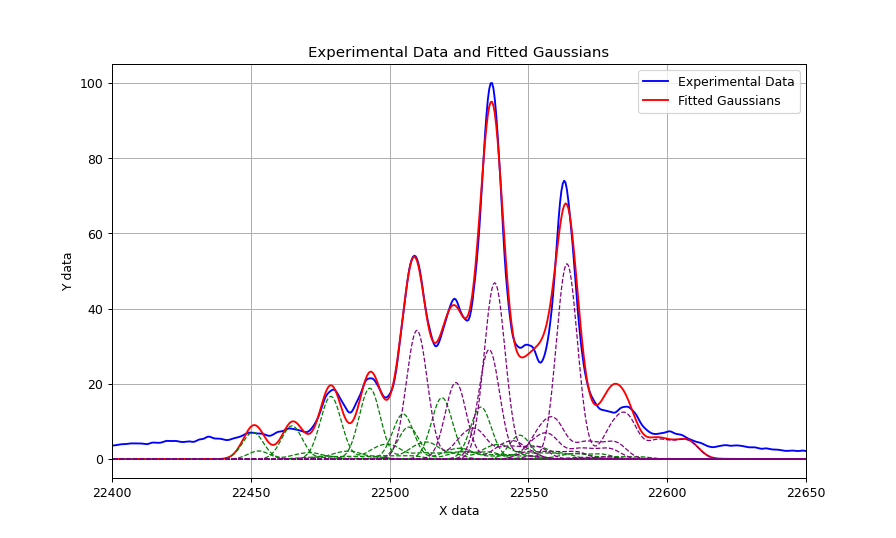

In [15]:
# Define a Gaussian function
def gaussian(x, a, b, c, d, e, f, g, h): 
    apo = a * np.exp(-((x - b) ** 2) / (2 * c ** 2)) 
    ox1 = a * d * np.exp(-((x - (b+16)) ** 2) / (2 * c ** 2)) 
    ox2 = a * e * np.exp(-((x - (b+32)) ** 2) / (2 * c ** 2)) 
    sod1 = a * f * np.exp(-((x - (b+22)) ** 2) / (2 * c ** 2))
    sod2 = a * g * np.exp(-((x - (b+44)) ** 2) / (2 * c ** 2))
    ox1sod1 = a * h * np.exp(-((x - (b+38)) ** 2) / (2 * c ** 2))
    return apo+ox1+ox2+sod1+sod2+ox1sod1


def sum_of_gaussians_with_fixed_centers_widths(x, *amplitudes):
    global centers, widths  # Assuming 'centers' and 'widths' are defined globally
    result = np.zeros_like(x)
    for i, amplitude in enumerate(amplitudes):
        result += gaussian(x, amplitude, centers[i], widths[i], 1.30688304e-01, 8.03289187e-02, 1.90123893e-01, 8.11248503e-02, 5.17646272e-02)
    return result



# Initial guesses for parameters (amplitude, center, width) for each Gaussian
amplitudes = list(overview_df['initial guess PE'])[0:9]+list(overview_df['initial guess PE'])[10:12]+list(overview_df['initial guess PG'])[4:]
centers = list(overview_df['complex mass PE'])[0:9]+list(overview_df['complex mass PE'])[10:12]+list(overview_df['complex mass PG'])[4:]  # Example centers
widths = [fwhm/2.355] * len(centers) 


# Bounds for parameters (adjust these based on your problem)
lower_bounds = []
upper_bounds = []
initial_guesses = []
for i, center in enumerate(centers):
    initial_guesses.append(amplitudes[i])
    lower_bounds.append(amplitudes[i]*0.1)
    upper_bounds.append(max(amplitudes[i]*10,0.01))


spec_x = np.array(spec_x)
spec_y = np.array(spec_y)
    
#print(*initial_guesses)
# Use curve_fit to fit the Gaussians to the experimental data
popt, pcov = curve_fit(sum_of_gaussians_with_fixed_centers_widths, spec_x, spec_y, p0=initial_guesses, bounds=(lower_bounds, upper_bounds))

#popt = initial_guesses

n_pe = len(list(overview_df['initial guess PE'])[0:9] + list(overview_df['initial guess PE'])[10:12])  # Update this based on your actual PE count

plt.figure(figsize=(10, 6))
plt.plot(spec_x, spec_y, 'b-', label='Experimental Data')
plt.plot(spec_x, sum_of_gaussians_with_fixed_centers_widths(spec_x, *popt), 'r-', label='Fitted Gaussians')
plt.xlim(22400, 22650)

# Loop through each Gaussian and plot with appropriate color
for i, amplitude in enumerate(popt):
    individual_gaussian = gaussian(spec_x, amplitude, centers[i], widths[i], 1.30688304e-01, 8.03289187e-02, 1.90123893e-01, 8.11248503e-02, 5.17646272e-02)
    
    # Determine the color based on PE or PG
    if i < n_pe:
        color = 'green'  # PE color
    else:
        color = 'purple'  # PG color

    # Plot the individual Gaussian with the determined color
    plt.plot(spec_x, individual_gaussian, color=color, linestyle='--', linewidth=1)

plt.xlabel('X data')
plt.ylabel('Y data')
plt.title('Experimental Data and Fitted Gaussians')
plt.legend()
plt.grid(True)
plt.show()



In [16]:
plt.savefig('output.pdf')

In [17]:
perr = np.sqrt(np.diag(pcov))

sum_errors = 0
for i, amplitude in enumerate(popt):
    print(f"{round(centers[i] - peakcenter + 22.99, 4)} {round(amplitude, 8)} {round(perr[i], 4)}")
    sum_errors += perr[i]**2
total_error = np.sqrt(sum_errors)
print(total_error)

684.457 7.10746251 2.0321
686.4726 2.15866451 2.048
698.4726 8.82494923 0.7525
710.4726 0.87618972 2.0679
712.4883 16.66876154 2.0591
726.5039 18.85080356 0.7853
738.5039 11.98540314 3.7249
740.5196 8.51917595 5.6041
752.5196 16.33584877 1.2017
766.5352 13.83126455 3.1199
780.5509 6.35309832 3.324
743.4883 34.23568877 2.818
757.5039 20.37163215 1.2033
769.5039 29.11914538 6.7884
771.5196 46.88544497 4.8713
783.5196 1.97166564 6.1481
785.5352 0.83446103 3.9469
797.5352 51.94446251 0.7724
811.5509 0.62742758 0.7446
14.807397053842632


In [70]:
perr = np.sqrt(np.diag(pcov))

sum_errors = 0
for i, amplitude in enumerate(popt):
    print(f"{round(centers[i] - peakcenter + 22.99, 4)} {round(amplitude, 8)} {round(perr[i], 4)}")
    sum_errors += perr[i]**2
total_error = np.sqrt(sum_errors)
print(total_error)

684.457 7.10746251 2.0321
686.4726 2.15866451 2.048
698.4726 8.82494923 0.7525
710.4726 0.87618972 2.0679
712.4883 16.66876154 2.0591
726.5039 18.85080356 0.7853
738.5039 11.98540314 3.7249
740.5196 8.51917595 5.6041
752.5196 16.33584877 1.2017
766.5352 13.83126455 3.1199
780.5509 6.35309832 3.324
743.4883 34.23568877 2.818
757.5039 20.37163215 1.2033
769.5039 29.11914538 6.7884
771.5196 46.88544497 4.8713
783.5196 1.97166564 6.1481
785.5352 0.83446103 3.9469
797.5352 51.94446251 0.7724
811.5509 0.62742758 0.7446
14.807397053842632
